In [2]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle
import matplotlib.pyplot as plt

In [3]:
#make the model
def create_model(J,Q,order,input_x,input_y,k_size,layer_size,nchan_out):
    #fname = random.choice(os.listdir(path_to_train))
    #rand_audio = os.path.join(path_to_train,fname)
    #y,sr = librosa.load(rand_audio)
    #N = len(y)
    #scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    
    #Sy = getsc_new(torch.Tensor(y),J,Q,order,scattering).T
    #nrow, ncol = Sy.shape 
    nrow = input_x
    ncol = input_y
    #naudio = batch_size         # number of images in batch
    nchan_in = 1       # number of input channels.  1 since it is BW
    #input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
    input_shape = (input_x,input_y)#Sy.shape
    #batch_shape = (naudio,nrow,ncol,nchan_in)  # shape of image batch
    #x = Sy.reshape(batch_shape)
    kernel_size = (k_size,)
    #nchan_out = 16

    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))
            if layer_size ==5:
                model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv5' ))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
                model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [4]:
J = 8
Q = 1
order = 2
pkl_path = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-train.pkl'
pkl_file = open(pkl_path, 'rb')
Sy_train,y_train = pickle.load(pkl_file) 

pkl_path_val = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-val.pkl'
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
#Sy_val = Sy_val.reshape((Sy_val.shape[2],Sy_val.shape[0],Sy_val.shape[1]))

pkl_path_test = "/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-test.pkl"
pkl_test = open(pkl_path_test,'rb')
Sy_test,y_test = pickle.load(pkl_test)

In [5]:
#fix everybody's physical parameters first (p and D should be log)
#print(np.log10(y_train[0,3]),y_train[0,3])
import math
for idx in range(2,4):
    y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
    y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]
    y_val[:,idx] = [math.log10(i) for i in y_val[:,idx]]

In [6]:
df_train = pd.read_csv("./train_param.csv")
df_test = pd.read_csv("./test_param.csv")
df_val = pd.read_csv("./val_param.csv")
df_full = pd.read_csv("./diffshapes_param.csv")

# normalization of the physical parameters
params = df_train.values[:,1:-1]
for idx in range(2,4):
    params[:,idx] = [math.log10(i) for i in params[:,idx]]

scaler = MinMaxScaler()
scaler.fit(params)

#normalize training and validation set
y_train_normalized = scaler.transform(y_train)
y_val_normalized = scaler.transform(y_val)
y_test_normalized = scaler.transform(y_test)

In [7]:
input_x = Sy_train.shape[1]
input_y = Sy_train.shape[2]

In [8]:
Sy_train_log2 = np.log1p(((Sy_train>0)*Sy_train)/1e-11)
Sy_val_log2 = np.log1p(((Sy_val>0)*Sy_val)/1e-11)
Sy_test_log2 = np.log1p((Sy_test>0)*Sy_test/1e-11)

In [9]:
print(np.max(np.max(np.max(Sy_train_log2))),np.min(np.min(np.min(Sy_train_log2))))

24.584995 -0.0


In [10]:
Sy_val_log2.shape

(7776, 128, 43)

(array([ 16.,  45.,  90.,  91.,  50.,  10.,   6.,  13.,  22.,  37.,  73.,
        102., 159., 227., 212., 199., 188., 130., 137., 131., 208., 214.,
        235., 184., 192., 245., 351., 460., 530., 492., 451., 313., 243.,
        192., 159., 135., 201., 212., 222., 226., 185., 125., 130., 135.,
        192., 161., 134.,  73.,  95.,  76., 132., 167., 142.,  98.,  47.,
         47.,  87., 159., 221., 228., 126.,  97., 130., 121.,  81.,  94.,
         81.,  53.,  22.,  13.,  11.,  32.,  36.,  67., 121., 153., 120.,
         84.,  88.,  66.,  27.,   1.,   1.,  35.,  56.,  80.,  95.,  32.,
          0.,   0.,   0.,  37.,  82., 109., 161., 224.,  95.,  75.,  83.,
         31.]),
 array([11.785914 , 11.9023075, 12.018701 , 12.135095 , 12.251488 ,
        12.367881 , 12.484274 , 12.600667 , 12.717061 , 12.833454 ,
        12.949847 , 13.06624  , 13.182633 , 13.2990265, 13.415421 ,
        13.531814 , 13.648207 , 13.7646   , 13.880993 , 13.997387 ,
        14.11378  , 14.230173 , 14.346566 , 14

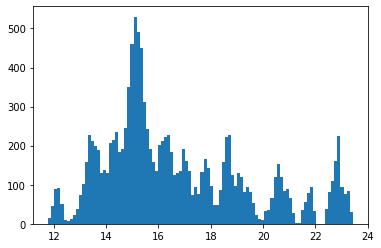

In [10]:
plt.hist(np.ndarray.flatten(Sy_val_log2[1:300,1,:]),100)

In [16]:
trial_dir = "../output/nonlinear_test2/"
best_validation_loss = np.inf
n = Sy_train.shape[0]
steps_per_epoch = 20
bs = 128
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss3=[]
train_loss3 = []
model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
for epoch in range(80):
    np.random.shuffle(idx)
    Sy_temp = Sy_train_log2[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    
    hist = model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=2,
                batch_size=bs,
                validation_data = (Sy_val_log2,y_val_normalized),
                use_multiprocessing=False)
    validation_loss = hist.history['val_loss'][0]
    val_loss3.append(validation_loss)
    train_loss3.append(hist.history['loss'][0])
   # if validation_loss < best_validation_loss:
   #     best_validation_loss = validation_loss
   #     epoch_str = "epoch-" + str(epoch).zfill(3)
   #     epoch_network_path = os.path.join(
   #        trial_dir, "_".join(["j8o2", epoch_str]) + "-log2.h5")
   #     model.save(epoch_network_path)
        

Train on 2560 samples, validate on 7776 samples
2560/2560 - 150s - loss: 0.5544 - mean_squared_error: 0.5544 - val_loss: 0.1306 - val_mean_squared_error: 0.1306
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.2372 - mean_squared_error: 0.2372 - val_loss: 0.1277 - val_mean_squared_error: 0.1277
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.1511 - mean_squared_error: 0.1511 - val_loss: 0.0997 - val_mean_squared_error: 0.0997
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.1025 - mean_squared_error: 0.1025 - val_loss: 0.0702 - val_mean_squared_error: 0.0702
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.0567 - val_mean_squared_error: 0.0567
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Train on 2560 samples, validate on 7776 samp

Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0693 - val_mean_squared_error: 0.0693
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0534 - val_mean_squared_error: 0.0534
Train on 2560 samples, validate on 7776 samples
2560/2560 - 0s - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Train on 2560 samples, validate on 7776 sample

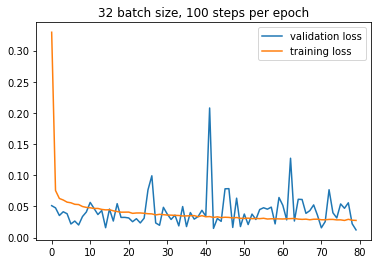

In [12]:
plt.plot(val_loss)
plt.plot(train_loss)
plt.legend(['validation loss','training loss'])
plt.title('32 batch size, 100 steps per epoch')
plt.show()

In [18]:
print(min(val_loss2),min(val_loss),min(val_loss3),min(train_loss2),min(train_loss),min(train_loss3))

0.011505790150613206 0.012286612620278274 0.018553992733359337 0.028375502564013003 0.027470613308250905 0.030904838349670172


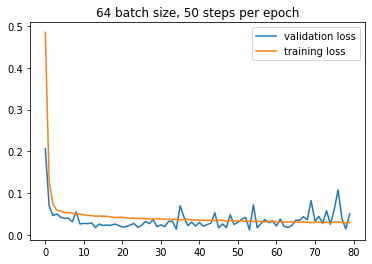

In [14]:
plt.plot(val_loss2)
plt.plot(train_loss2)
plt.legend(['validation loss','training loss'])
plt.title('64 batch size, 50 steps per epoch')
plt.show()

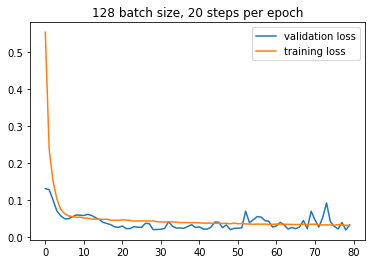

In [17]:
plt.plot(val_loss3)
plt.plot(train_loss3)
plt.legend(['validation loss','training loss'])
plt.title('128 batch size, 20 steps per epoch')
plt.show()

In [32]:
i=1200
original = y_test_normalized[i,:]
Sx = Sy_test_log2[i,:,:]
recovered = model.predict(Sx.reshape((1,128,43)))
print(original,recovered)

[0.13351093 0.94689495 0.7847013  0.79656343 0.28849735] [[-0.11454172  0.7541124   0.5277499   0.5947709   0.33286726]]


In [43]:
print(original,recovered)

[0.07411863 0.84310174 0.55710213 0.29067493 0.91585758] [[0.50843346 0.4044962  0.436315   0.616282   0.67034876]]


In [47]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model2.load_weights("../output/nonlinear_test2/j8o2_epoch-077-log2.h5")

## best model so far is batch 32 step size 100 for 77 epochs
how is it doing on each physical parameter?

according to ground truth labels, all parameters are uniformly distributed

In [48]:
model2

In [74]:
b = []
a = [1,2,3]
b.append(a)
b.append(a)
np.stack(b)
print(b)

[[1, 2, 3], [1, 2, 3]]


In [49]:
diff = []
for i in range(4000):
    original = y_test_normalized[i,:]
    Sx = Sy_test_log2[i,:,:]
    recovered = model2.predict(Sx.reshape((1,128,43)))
    diff.append(recovered-original)
diff_stacked = np.stack(np.abs(diff))

how does each physcial parameter error looks like"

In [51]:
diff_stacked = diff_stacked.reshape((4000,5))

{'whiskers': [<matplotlib.lines.Line2D at 0x2b07ba007210>,
 'caps': [<matplotlib.lines.Line2D at 0x2b08cffbc0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b07ba007cd0>,
 'medians': [<matplotlib.lines.Line2D at 0x2b080ff9aad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b080ff9a890>,
 'means': []}

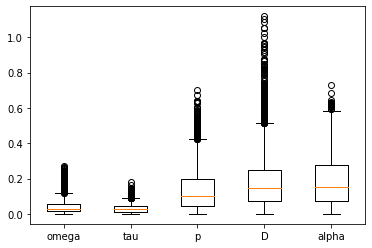

In [52]:
labels = ['omega','tau','p','D','alpha']
plt.boxplot(diff_stacked,labels = labels)

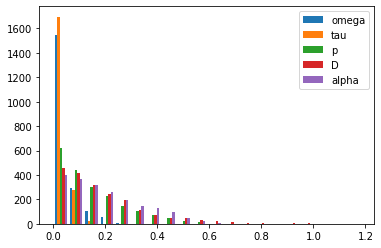

In [88]:
plt.hist(diff_stacked[:,0,:],20)
plt.legend(['omega','tau','p','D','alpha'])

(array([322., 221., 156., 119.,  73.,  49.,  28.,  23.,   6.,   3.]),
 array([6.52339268e-05, 6.26760694e-02, 1.25286905e-01, 1.87897740e-01,
        2.50508576e-01, 3.13119411e-01, 3.75730247e-01, 4.38341082e-01,
        5.00951917e-01, 5.63562753e-01, 6.26173588e-01]),
 <a list of 10 Patch objects>)

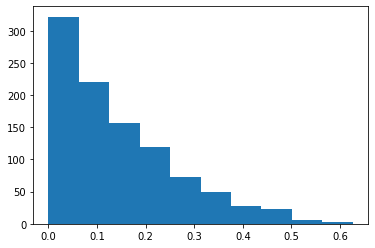

In [80]:
plt.hist(diff_stacked[:,0,2])

In [65]:
i=1199
original = y_train_normalized[i,:]
Sx = Sy_train_log2[i,:,:]
recovered = model2.predict(Sx.reshape((1,128,43)))
print(original,recovered)

[0.91303774 0.93262884 0.77100404 0.29490739 0.30083545] [[0.86738974 0.94374514 0.77592707 0.34002268 0.35929015]]


In [57]:
model2.evaluate(Sy_test_log2,y_test_normalized)

10000/10000 [==============================] - 1s 123us/sample - loss: 0.0314 - mean_squared_error: 0.0314


[0.031431474763154985, 0.031431478]

In [58]:
model2.evaluate(Sy_train_log2,y_train_normalized)

82224/82224 [==============================] - 9s 110us/sample - loss: 0.0315 - mean_squared_error: 0.0315


[0.031536917375245895, 0.031536873]

In [59]:
model2.evaluate(Sy_val_log2,y_val_normalized)

7776/7776 [==============================] - 1s 111us/sample - loss: 0.0121 - mean_squared_error: 0.0121


[0.01209811591294138, 0.012098117]

In [25]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
recovereds=[]
for i in range(1,30):
    if i<10:
        num="00"+str(i)
    else:
        num="0"+str(i)
    model2.load_weights("../output/j8o2_epoch-"+num+"-log2.h5")
    idx=900
    original = y_test_normalized[idx,:]
    Sx = Sy_test_log2[idx,:,:]
    recovered = model2.predict(Sx.reshape((1,128,43)))
    recovereds.append(recovered)
print(original,recovereds)

[0.18508676 0.15778566 0.83393416 0.6973833  0.38978658] [array([[ 0.12924188, -0.01282368, -0.01827345,  0.00709136,  0.1449491 ]],
      dtype=float32), array([[ 0.16703765,  0.03420937, -0.01650573,  0.03284939,  0.15856506]],
      dtype=float32), array([[0.17951101, 0.15352775, 0.00698536, 0.03333293, 0.1192532 ]],
      dtype=float32), array([[0.19032335, 0.23737423, 0.06644126, 0.04796477, 0.10021573]],
      dtype=float32), array([[0.22111303, 0.30277777, 0.05979192, 0.08614463, 0.09556869]],
      dtype=float32), array([[0.23447618, 0.36542296, 0.0795739 , 0.09382316, 0.08278787]],
      dtype=float32), array([[0.25511226, 0.4268223 , 0.1088834 , 0.15652221, 0.12793535]],
      dtype=float32), array([[0.28713715, 0.4589598 , 0.11357147, 0.2260835 , 0.17895496]],
      dtype=float32), array([[0.33276492, 0.48091692, 0.13084042, 0.31558216, 0.27293137]],
      dtype=float32), array([[0.34118453, 0.5241515 , 0.18215108, 0.34584472, 0.27927658]],
      dtype=float32), array([[0.36

In [27]:
model3=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model3.load_weights("../output/j8o2_epoch-001-log2.h5")
recovereds=[]
for i in range(1,30):
    idx=i
    original = y_test_normalized[idx,:]
    Sx = Sy_test_log2[idx,:,:]
    recovered = model3.predict(Sx.reshape((1,128,43)))
    recovereds.append(recovered)
print(original,recovereds)

[0.73148035 0.71185277 0.5859216  0.68880883 0.92923907] [array([[ 0.16870654, -0.11933641,  0.04332103,  0.09887189,  0.2645198 ]],
      dtype=float32), array([[0.11705386, 0.04620991, 0.0359511 , 0.07052191, 0.08028968]],
      dtype=float32), array([[ 0.11820751,  0.11773452, -0.02517378,  0.02660449,  0.0588664 ]],
      dtype=float32), array([[ 0.18399005, -0.12796356,  0.03819741,  0.07275039,  0.22930585]],
      dtype=float32), array([[0.11751596, 0.03906371, 0.03433005, 0.07067346, 0.08705397]],
      dtype=float32), array([[ 0.1794035 , -0.17564707,  0.09821105,  0.12537543,  0.322071  ]],
      dtype=float32), array([[ 1.4711931e-01, -2.6992422e-02,  9.5795840e-06,  5.8835857e-02,
         1.8940987e-01]], dtype=float32), array([[ 0.11390976,  0.07119198, -0.00798965,  0.03873477,  0.10203451]],
      dtype=float32), array([[ 0.11177225,  0.13923319, -0.01978726,  0.05249289,  0.05641059]],
      dtype=float32), array([[ 0.14948045, -0.00928066,  0.02754237,  0.05446425,  0

## Adjustable input training  pipeline

In [9]:
N = 2**15
y = np.random.rand(N)
scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
Sy = np.array(scattering(torch.Tensor(y))).T
print(Sy.shape)

(128, 43)


In [26]:
#make the model
#zoom factor can only be 1/4, 1/2
def create_model_adjustable(J,Q,order,k_size,nchan_out,zoom_factor,activation):
    N = 2**15
    y = np.random.rand(N)
    scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    Sy = np.array(scattering(torch.Tensor(y))).T
    input_x,input_y = Sy.shape
    nchan_in = 1       # number of input channels.  1 since it is BW
  
    #adjustable input dimension!!!!
    if zoom_factor == 0.5:
        layer_size = 3
    elif zoom_factor == 0.25:
        layer_size = 2
    elif zoom_factor == 1:
        layer_size = 4
        
    zoomed_x = round(input_x * zoom_factor)
    
    
    input_shape = (zoomed_x,input_y)#Sy.shape
    kernel_size = (k_size,)
    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))
            if layer_size ==5:
                model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv5' ))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
                model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation=activation)) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [56]:
#model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model_adjustable = create_model_adjustable(J=8,Q=1,order=2,k_size=8,nchan_out=16,zoom_factor=0.25,activation='linear')
model_adjustable.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 32, 16)            5520      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 16)            64        
_________________________________________________________________
activation (Activation)      (None, 32, 16)            0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 8, 16)             0         
_________________________________________________________________
conv2 (Conv1D)               (None, 8, 16)             2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 16)             64        
_________________________________________________________________
activation_1 (Activation)    (None, 8, 16)             0

In [13]:
a=[1,2,3]
print(a[-2:])

[2, 3]


In [44]:
#trial_dir = "../output/nonlinear_test3/"
best_validation_loss = np.inf
zoom_factor = 1
n = Sy_train.shape[0]
shape_time = round(Sy_train.shape[1] * zoom_factor)
steps_per_epoch = 20
bs = 120
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss3=[]
train_loss3 = []
model_adjustable = create_model_adjustable(J=8,Q=1,order=2,k_size=8,nchan_out=16,zoom_factor=zoom_factor,activation='sigmoid')
#model_adjustable.summary()
for epoch in range(30):
    np.random.shuffle(idx)
    Sy_temp = Sy_train_log2[idx[:m],:shape_time,:]
    y_temp = y_train_normalized[idx[:m],:]
    
    hist = model_adjustable.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=2,
                batch_size=bs,
                validation_data = (Sy_val_log2[:,-shape_time:,:],y_val_normalized),
                use_multiprocessing=False)
    validation_loss = hist.history['val_loss'][0]
    val_loss3.append(validation_loss)
    train_loss3.append(hist.history['loss'][0])
   # if validation_loss < best_validation_loss:
   #     best_validation_loss = validation_loss
   #     epoch_str = "epoch-" + str(epoch).zfill(3)
   #     epoch_network_path = os.path.join(
   #        trial_dir, "_".join(["j8o2", epoch_str]) + "-log2.h5")
   #     model.save(epoch_network_path)
        

Train on 2400 samples, validate on 7776 samples
2400/2400 - 1s - loss: 0.0809 - mean_squared_error: 0.0809 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Train on 2400 samples, validate on 7776 samples
2400/2400 - 1s - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Train on 2400 samples, validate on 7776 samples
2400/2400 - 1s - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Train on 2400 samples, validate on 7776 samples
2400/2400 - 1s - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Train on 2400 samples, validate on 7776 samples
2400/2400 - 1s - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Train on 2400 samples, validate on 7776 samples
2400/2400 - 1s - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Train on 2400 samples, validate on 7776 sample

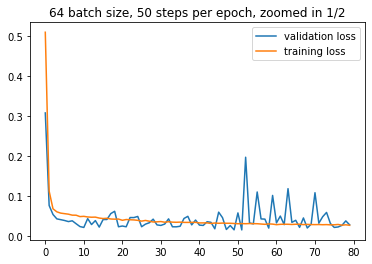

In [52]:
plt.plot(val_loss4)
plt.plot(train_loss4)
plt.legend(['validation loss','training loss'])
plt.title('64 batch size, 50 steps per epoch, zoomed in 1/2')
plt.show()

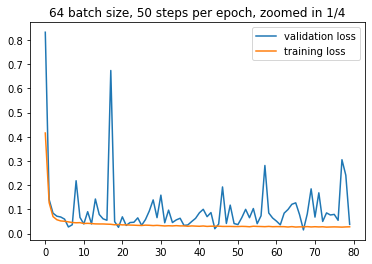

In [60]:
plt.plot(val_loss5)
plt.plot(train_loss5)
plt.legend(['validation loss','training loss'])
plt.title('64 batch size, 50 steps per epoch, zoomed in 1/4')
plt.show()

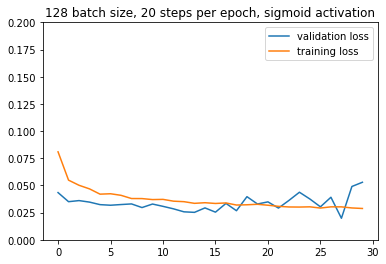

In [45]:
plt.plot(val_loss3)
plt.plot(train_loss3)
plt.legend(['validation loss','training loss'])
plt.title('128 batch size, 20 steps per epoch, sigmoid activation')
plt.ylim([0,0.2])
plt.show()

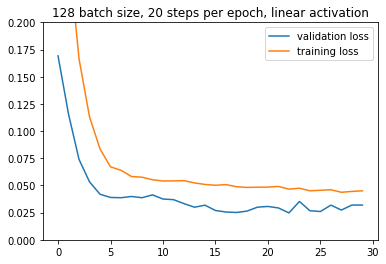

In [43]:
plt.plot(val_loss4)
plt.plot(train_loss4)
plt.legend(['validation loss','training loss'])
plt.title('128 batch size, 20 steps per epoch, linear activation')
plt.ylim([0,0.2])
plt.show()

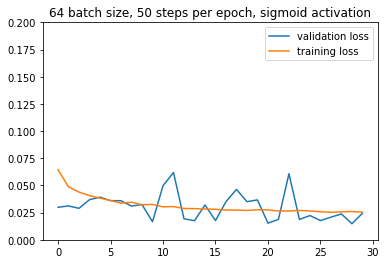

In [40]:
plt.plot(val_loss5)
plt.plot(train_loss5)
plt.legend(['validation loss','training loss'])
plt.ylim([0,0.2])
plt.title('64 batch size, 50 steps per epoch, sigmoid activation')
plt.show()

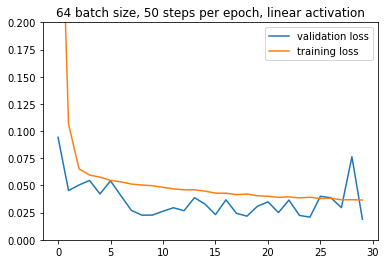

In [37]:
plt.plot(val_loss6)
plt.plot(train_loss6)
plt.legend(['validation loss','training loss'])
plt.title('64 batch size, 50 steps per epoch, linear activation')
plt.ylim([0,0.2])
plt.show()